In [131]:
# Packages for astro related data analysis
from astropy.io import fits
from astropy import units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.timeseries import LombScargle
from scipy.optimize import curve_fit
from scipy import odr

# Packages for simbad and ZTF queries
from astroquery.simbad import Simbad
from astroquery.ipac.irsa import Irsa
import requests

# Generally useful packages
import matplotlib.pyplot as plt  
import numpy as np
import pandas as pd
import os

# packages for plot formatting
import seaborn as sns 
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize

In [168]:
# This function uses a lomb-scargle from astropy to calculate the most likely period
def find_period(mag, mjd, magerr):
    frequency, power = LombScargle(mjd.value, mag, dy=magerr, fit_mean=False).autopower(method='chi2', minimum_frequency=0.002, maximum_frequency=0.05)

    # Find two best period (since lomb-scargle returns it in frequency)
    # I use sorted arrays since I dont need to retain index information
    period = 1/frequency[np.argsort(power)[-1]]
    
    return period, frequency, power

# This function plots the phase-folded lightcurve based on our period to visually confirm best period :)
def phase_fold(mag, mjd, magerr, period, name, frequency, power, uncertainty, imag): 
    print(np.nanmax(power) / np.nanmean(power))
    # Calculate phases for data
    minindex = np.where(mag == np.nanmin(mag))[0][0]
    reference_time = mjd[minindex] 
    phases = ((mjd.value - reference_time) / period) % 1
    
    # Sort data based on phases for plotting
    sorted_indices = np.argsort(phases)
    sorted_phases = phases[sorted_indices]
    sorted_mag = mag[sorted_indices]
    sorted_magerr = magerr[sorted_indices]
    mean, std = np.mean(sorted_mag), np.std(sorted_mag)

    # define bin ranges
    bin_ranges = np.arange(0,2.1,0.1)
    # fuse data into bins
    bins = np.digitize(sorted_phases, bin_ranges) -1 
    # array for average value in bin
    bin_averages, bin_std = [],[]
    # take average for each bin
    for i in range(len(bin_ranges)-1):
        bin_mags = sorted_mag[bins == i]
        bin_averages.append(np.median(bin_mags))
        bin_std.append(np.std(bin_mags))
    
    # Set up plot style
    sns.set_theme(style="ticks")
    plt.rcParams.update({'font.family':'serif'})
    
    # Set up figure format
    fig = plt.figure(figsize=(12, 5))
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    fig.suptitle(r'Period of {}'.format(name), fontsize=14)
    fig.patch.set_facecolor('lightgray')
    fig.patch.set_edgecolor('navy')

    # set up figure formats
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])

    # Plot phase folded lightcurve
    ax1.scatter(sorted_phases, sorted_mag, color='royalblue', label='Phase Folded Magnitudes')

    # plot the binned magnitudes and the interval of confidence 
    ax1.plot(bin_ranges[0:-1], bin_averages, color='mediumorchid', label='Median Binned Magnitudes', lw=2)
    ax1.plot(bin_ranges[0:-1], np.array(bin_averages)+np.array(bin_std), color='mediumseagreen', lw=2, ls='--')
    ax1.plot(bin_ranges[0:-1], np.array(bin_averages)-np.array(bin_std), color='mediumseagreen', lw=2, ls='--')
    ax1.fill_between(bin_ranges[0:-1], bin_averages, np.array(bin_averages)+np.array(bin_std), label = r'1$\sigma$ Mean Magntiude Region', color='limegreen', alpha=0.3)
    ax1.fill_between(bin_ranges[0:-1], bin_averages, np.array(bin_averages)-np.array(bin_std), color='limegreen', alpha=0.3)
    ax1.legend(loc=4, fontsize=8)

    # plot periogram as the secondary plot along with 1 sigma confidence level for period
    ax2.plot(frequency, power, color='royalblue', label='Power at given Frequency')
    bestfreq = frequency.value[np.argmax(power.value)]
    ax2.axvline(bestfreq, color='mediumorchid', label='Frequency at Greatest Power', ls='--', lw=2)
    x = np.where((frequency <= 1/(1/bestfreq - uncertainty)) & (frequency >= 1/(1/bestfreq + uncertainty)))[0]
    ax2.fill_between(frequency[x], 0, power[x], color='limegreen', label=r'1$\sigma$ Period Region', alpha=0.3)
    ax2.legend(loc=1, fontsize=8)
    ax2.text(0.0175, np.nanmax(power),
        r'I Mag:{} Period:{}$\pm${} {}'.format(round(float(imag), 2), round(period.value,1), round(uncertainty, 2), round(np.nanmax(power.value)/np.nanmean(power.value), 2)),
        fontsize=9,
        horizontalalignment='center',
        verticalalignment='top')

    # plot labels and limits
    ax1.set_ylabel(f'm$_V$', fontsize=12)
    ax1.set_xlabel(f'Phase', fontsize=12)
    ax1.set_ylim(mean-2*std, mean+2*std)
    
    # tick formatting
    ax1.minorticks_on()
    ax1.tick_params(axis='both', which='major', labelsize=10,direction='in')
    ax1.tick_params(axis='both', which='minor', labelsize=6,direction='in')

    #plt.ylim(np.max(sorted_mag), 13)
    #ax1.set_aspect(aspect='auto')
    ax1.set_facecolor('white')
    ax1.grid(False)

    # plot labels and limits
    ax2.set_ylabel(f'Power', fontsize=12)
    ax2.set_xlabel(f'Frequency', fontsize=12)
    
    # tick formatting
    ax2.minorticks_on()
    ax2.tick_params(axis='both', which='major', labelsize=10,direction='in')
    ax2.tick_params(axis='both', which='minor', labelsize=6,direction='in')

    #plt.ylim(np.max(sorted_mag), 13)
    ax2.set_aspect(aspect='auto')
    ax2.set_facecolor('white')
    ax2.grid(False)
    #plt.savefig(os.path.join('/Users/thomas/Downloads/', '{}'.format(name))) 
    plt.show()
    plt.close()

# This function calculates the signal to noise ratio based off of the avergae magnitude over root-mean-sqaured times the length of observation
def error(frequencys, powers):
    # Lets calculate SNR
    frequency_max, frequency_min = np.max(frequencys), np.min(frequencys)
    avg_power = np.mean(power)
        
    # Calculate the RMS of the flux values (normalized by the wavelength range width)
    rms_normalized = np.sqrt(np.sum(((power - avg_power) / (frequency_max - frequency_min)) ** 2) / (len(frequencys)))
    
    # Calculates SNR from normalized region
    rms_IRAF_style = (frequency_max - frequency_min) * rms_normalized
    err = (avg_power)/rms_IRAF_style
    return err

# This function inserts random noise by using the mean over the SNR as bounds for the noise added  
def simulate_power_noise(original_power, snr):
    noise = np.random.normal(0, np.abs(np.nanmean(original_power)) / snr, size=original_power.shape)
    return original_power + noise

#This is the monte carlo function, I do 1000 runs and take STD 
def monte_carlo(frequencys, powers):
    # call snr function
    snr = error(frequencys, powers)
    synth_period = []
    # do 1000 simulations of periods
    for _ in range(1000):
        simulated_power = simulate_power_noise(powers, snr)
        sim_period = 1/frequencys.value[np.argmax(simulated_power)]
        synth_period.append(sim_period)
        
    #print(synth_period)    
    # returns standard deviation of found periods 
    return np.std(np.array(synth_period))

# Calculate bolemtric magntiude 
def abs_mag(mag, dis):
    return mag - 5*np.log10(100*dis)

# Query the ZTF database for our TRGBs
def ztf_obj(ra, dec):
    # Define the position (RA, Dec) and search radius of TRGBs
    position = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs')  # Example: near Andromeda Galaxy
    radius = 2.0 * u.arcsec  # Search radius in arcminutes
    
    # Perform the cone search
    result = Irsa.query_region(position, catalog=catalog, spatial='Cone', radius=radius)

    # if any TRGBs are listed
    if result is not None and len(result) > 0:
        # Gather data with the most data points in visual filter
        nobs = 1
        object_id = 0
        for i, row in enumerate(result):
            if row['nobs'] > nobs and row['filtercode'] == 'zg': 
                nobs = row['nobs']
                # Get object ID to request data via url link
                object_id = row['oid']

        if object_id != 0:
            # Construct URL link for ztf the light curve
            lightcurve_url = f"https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?ID={object_id}&FORMAT=ipac_table"
                    
            # Construct table produced by ZTF URL
            t = requests.get(lightcurve_url).text
            return t   

# absolute magnitude uncertainty
def abs_mag_uncertainty(dist, dist_uncertainty):
    # Using uncertaintity from distance measurement and distances via distance modulus equation we arrive to this uncertaintty equation
    return 5 * dist_uncertainty / (dist * np.log(10))

# CMD plots 
def cmd(result, j):
    # If there are any RGBs in the cluster
    if result is not None:
        # Gather useful info for RGBs
        name = result["MAIN_ID"]
        ra = result["RA"]
        dec = result["DEC"]
        b = result['FLUX_B']
        v = result['FLUX_V']
        i = result['FLUX_I']
        dis = distance[j]
        dis_err = diserror[j]
        
        # use parallax of cluster to give proxy of magnitude
        I = abs_mag(i, dis)
        
        # b-v of RGBs
        vi = v - i

        # std and mean for threshold
        stdm, stdc = np.std(v), np.mean(vi)
        meanm, meanc = np.mean(v), np.mean(vi)
        
        # color magnitude diagram!
        fig, ax = plt.subplots() 
        ax.set_title('{}'.format(glclist[j]))
        ax.scatter(vi, I)
        ax.invert_yaxis()

        # parameters for out TRGB stars
        v_trgb = v[(I <= -3.5) & (I >= -4.5)]
        i_trgb = I[(I <= -3.5) & (I >= -4.5)]
        vi_trgb = vi[(I <= -3.5) & (I >= -4.5)]
        ra_trgb = ra[(I <= -3.5) & (I >= -4.5)]
        dec_trgb = dec[(I <= -3.5) & (I >= -4.5)]
        name_trgb = name[(I <= -3.5) & (I >= -4.5)]
        vi_non = vi[(I >= -3.5)]
        I_non = I[(I >= -3.5)]
        
        mag_err = [abs_mag_uncertainty(dis, dis_err[0]), abs_mag_uncertainty(dis, dis_err[1])]

        # highlight stars in our threshold for TRGBs
        ax.scatter(vi_trgb, i_trgb)
        plt
        plt.show()
        plt.close()

        # only outputs data for TRGB stars
        return i_trgb.value, vi_trgb.value, ra_trgb.value, dec_trgb.value, name_trgb, I_non.value, vi_non.value, mag_err

In [133]:
# Set up Simbad parameters (aka I want these numbers but I have to tell simbad call them)
simbad = Simbad()
simbad.add_votable_fields("otype")
simbad.add_votable_fields("flux(B)")
simbad.add_votable_fields("flux(V)")
simbad.add_votable_fields("flux(I)")
simbad.add_votable_fields("dim")

# Specify the ZTF catalog
catalog = "ztf_objects_dr22"

In [134]:
# Simbad query function for globular clusters above magnitde 17 and above declination of -20 (Threshold for ZTF)
globs = simbad.query_criteria('maintype = GlC & Vmag < 17 & dec > -30')

# Gathers key info on Globular Clsuters
glra = globs['RA']
gldec = globs['DEC']
glsize = globs['GALDIM_MAJAXIS']
glname = globs['MAIN_ID']


In [135]:
for glob in globs:
    print(glob)

   MAIN_ID          RA         DEC     RA_PREC DEC_PREC COO_ERR_MAJA COO_ERR_MINA COO_ERR_ANGLE COO_QUAL COO_WAVELENGTH COO_BIBCODE    OTYPE    FLUX_B FLUX_V FLUX_I GALDIM_MAJAXIS GALDIM_MINAXIS GALDIM_ANGLE SCRIPT_NUMBER_ID
                 "h:m:s"     "d:m:s"                        mas          mas           deg                                                       mag    mag    mag       arcmin         arcmin         deg                      
-------------- ----------- ----------- ------- -------- ------------ ------------ ------------- -------- -------------- ----------- ----------- ------ ------ ------ -------------- -------------- ------------ ----------------
FJJ NGC 147 II 00 33 15.17 +48 27 23.2       6        6           --           --             0        D                            GlobCluster   17.1   16.5     --             --             --            0                0
    MAIN_ID          RA         DEC     RA_PREC DEC_PREC COO_ERR_MAJA COO_ERR_MINA COO_ERR_ANGLE COO

In [136]:
glclist = ['M5', 'M10', 'NGC 5634', 'NGC 5466', 'M4', 'NGC 2419', 'M22', 'M79', 'M68']
distance = [7.479, 5.067, 25.959, 16.120, 1.851, 88.471, 3.303, 13.078, 10.404, 8.988]
diserror = [[0.06, 0.06], [0.064, 0.063], [0.628, 0.613], [0.164, 0.162], [0.015, 0.016], [2.437, 2.371], [0.037, 0.037], [0.181, 0.179], [0.1, 0.099]] 

glra, gldec, glsize, gldistance = [],[],[],[]
for glob in glclist:
    query = simbad.query_object(glob)
    display(query)

    glra.append(query['RA'][0])
    gldec.append(query['DEC'][0])
    glsize.append(query['GALDIM_MAJAXIS'][0])

<Table length=1>
MAIN_ID      RA         DEC     ... GALDIM_MINAXIS GALDIM_ANGLE SCRIPT_NUMBER_ID
          "h:m:s"     "d:m:s"   ...     arcmin         deg                      
 object    str13       str13    ...    float32        int16          int32      
------- ----------- ----------- ... -------------- ------------ ----------------
  M   5 15 18 33.22 +02 04 51.7 ...           17.4           90                1

<Table length=1>
MAIN_ID      RA         DEC     ... GALDIM_MINAXIS GALDIM_ANGLE SCRIPT_NUMBER_ID
          "h:m:s"     "d:m:s"   ...     arcmin         deg                      
 object    str13       str13    ...    float32        int16          int32      
------- ----------- ----------- ... -------------- ------------ ----------------
  M  10 16 57 09.05 -04 06 01.1 ...           15.1           90                1

<Table length=1>
 MAIN_ID       RA         DEC     ... GALDIM_ANGLE SCRIPT_NUMBER_ID
            "h:m:s"     "d:m:s"   ...     deg                      
  object     str13       str13    ...    int16          int32      
--------- ----------- ----------- ... ------------ ----------------
NGC  5634 14 29 37.28 -05 58 35.1 ...            0                1

<Table length=1>
 MAIN_ID       RA         DEC     ... GALDIM_ANGLE SCRIPT_NUMBER_ID
            "h:m:s"     "d:m:s"   ...     deg                      
  object     str13       str13    ...    int16          int32      
--------- ----------- ----------- ... ------------ ----------------
NGC  5466 14 05 27.29 +28 32 04.0 ...           90                1

<Table length=1>
MAIN_ID      RA         DEC     ... GALDIM_MINAXIS GALDIM_ANGLE SCRIPT_NUMBER_ID
          "h:m:s"     "d:m:s"   ...     arcmin         deg                      
 object    str13       str13    ...    float32        int16          int32      
------- ----------- ----------- ... -------------- ------------ ----------------
  M   4 16 23 35.22 -26 31 32.7 ...           26.3           90                1

<Table length=1>
 MAIN_ID       RA         DEC     ... GALDIM_ANGLE SCRIPT_NUMBER_ID
            "h:m:s"     "d:m:s"   ...     deg                      
  object     str13       str13    ...    int16          int32      
--------- ----------- ----------- ... ------------ ----------------
NGC  2419 07 38 08.51 +38 52 54.9 ...           90                1

<Table length=1>
MAIN_ID      RA         DEC     ... GALDIM_MINAXIS GALDIM_ANGLE SCRIPT_NUMBER_ID
          "h:m:s"     "d:m:s"   ...     arcmin         deg                      
 object    str13       str13    ...    float32        int16          int32      
------- ----------- ----------- ... -------------- ------------ ----------------
  M  22 18 36 23.94 -23 54 17.1 ...           24.0           90                1

<Table length=1>
MAIN_ID      RA         DEC     ... GALDIM_MINAXIS GALDIM_ANGLE SCRIPT_NUMBER_ID
          "h:m:s"     "d:m:s"   ...     arcmin         deg                      
 object    str13       str13    ...    float32        int16          int32      
------- ----------- ----------- ... -------------- ------------ ----------------
  M  79 05 24 10.59 -24 31 27.3 ...            8.7           90                1

<Table length=1>
MAIN_ID      RA         DEC     ... GALDIM_MINAXIS GALDIM_ANGLE SCRIPT_NUMBER_ID
          "h:m:s"     "d:m:s"   ...     arcmin         deg                      
 object    str13       str13    ...    float32        int16          int32      
------- ----------- ----------- ... -------------- ------------ ----------------
  M  68 12 39 27.98 -26 44 38.6 ...           12.0           90                1

In [137]:
# Array for results
results = []
# For each globuar cluster ...
for i, j, k in zip(glra, gldec, glsize):
    # seacrh for RGB stars in the reigon of the globular cluster
    results.append(simbad.query_criteria('maintype = RGB* & region(circle, {} {}, {}m)'.format(i, j, k)))

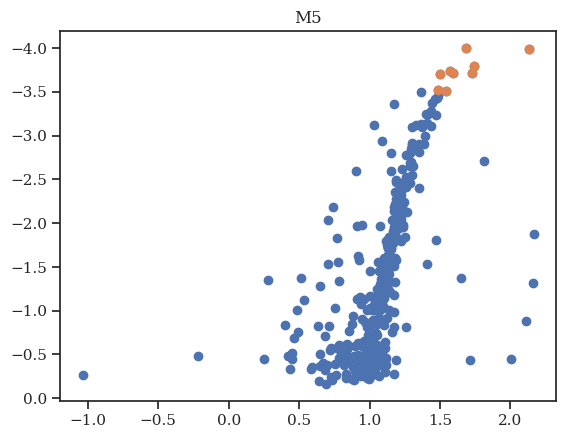

10
15 18 29.3839 +02 08 27.637 -3.5155181884765625
8.75046079892107


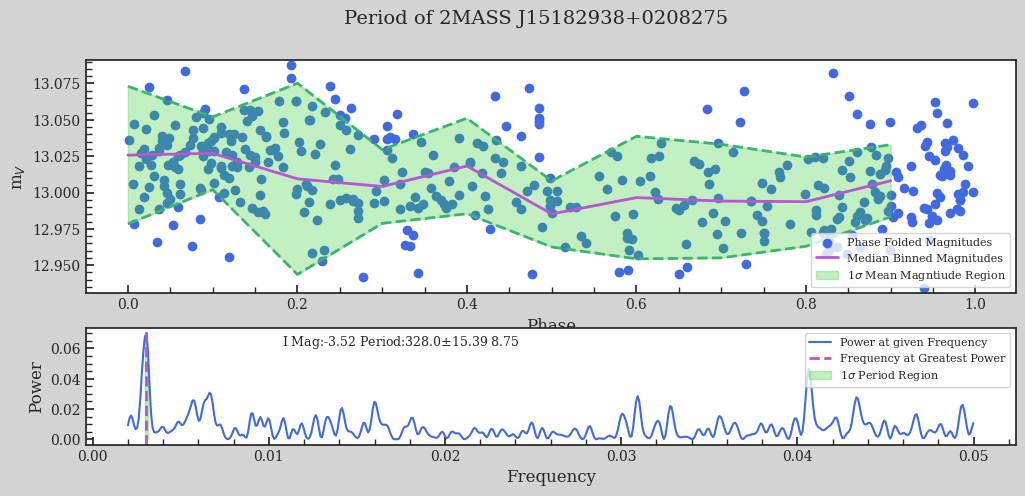

15 18 44.9526 +02 02 03.568 -3.7403182983398438
6.833773447741139


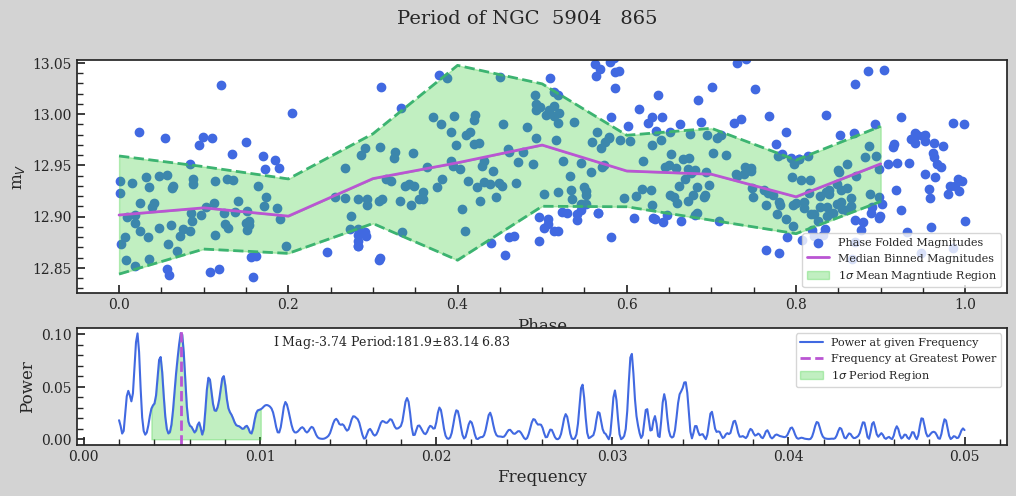

15 18 24.9948 +02 03 09.925 -3.712517738342285
4.856530065483031


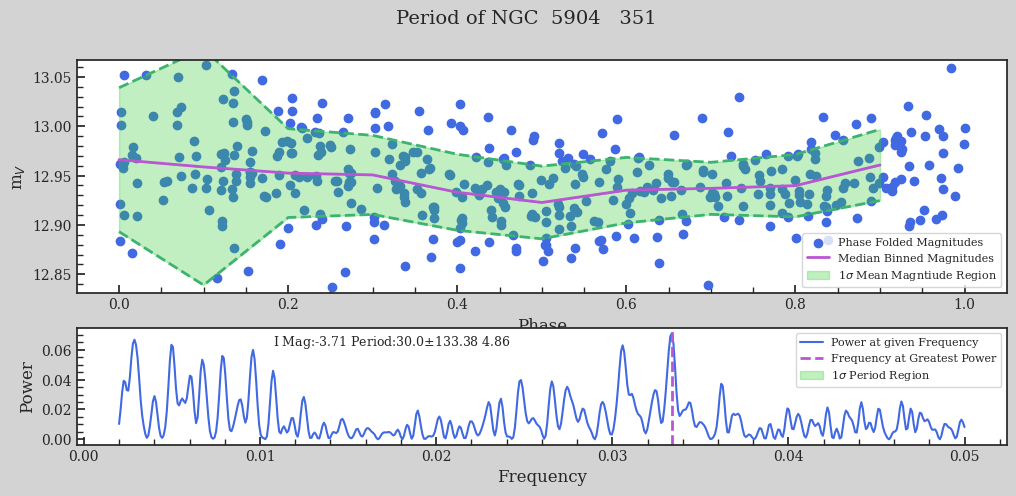

15 18 31.5983 +02 04 41.164 -3.9998178482055664
7.235564051024713


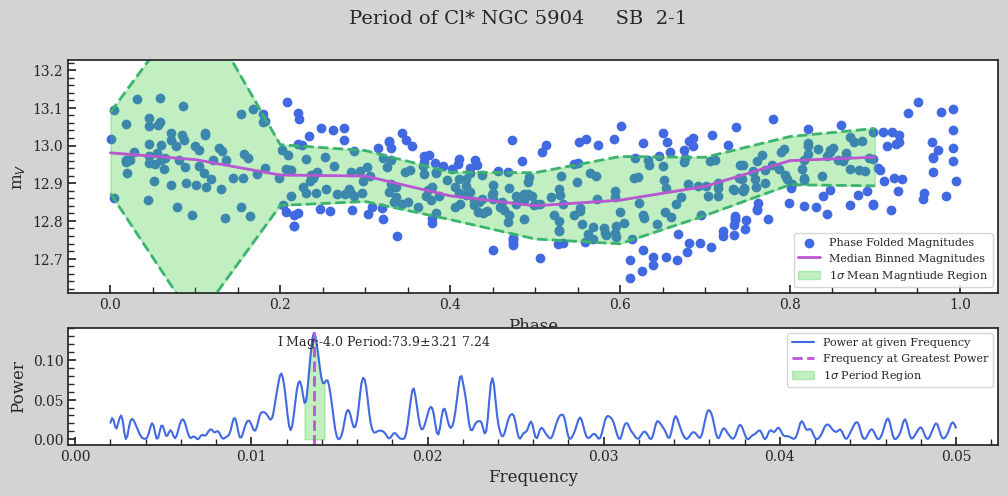

15 18 36.0397 +02 06 37.521 -3.985017776489258
37.96402955870876


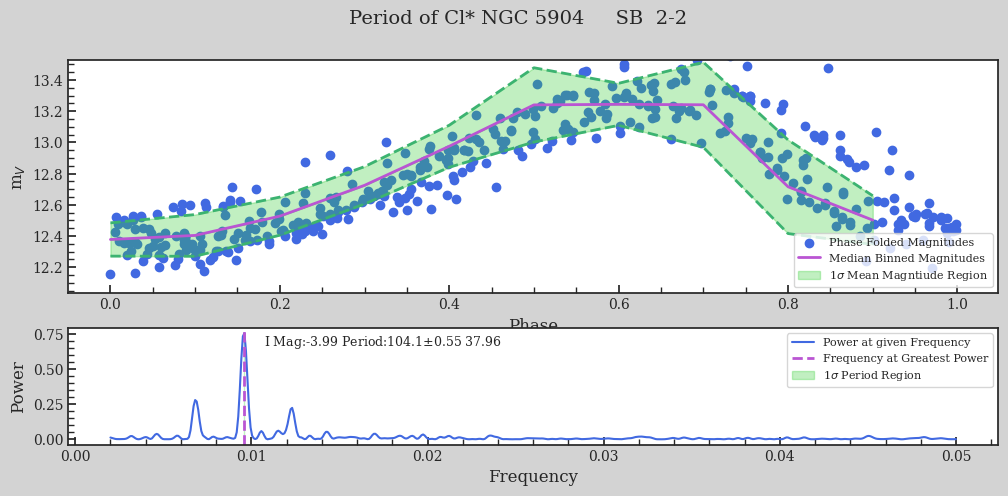

15 18 34.8095 +02 04 14.258 -3.808717727661133
20.922973855737844


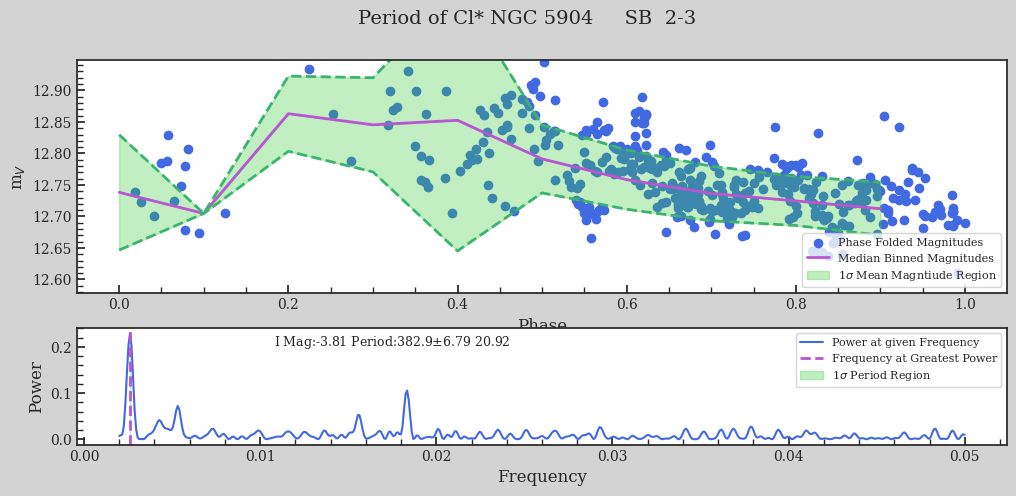

15 18 33.4257 +02 04 59.315 -3.7951183319091797
7.938302082469379


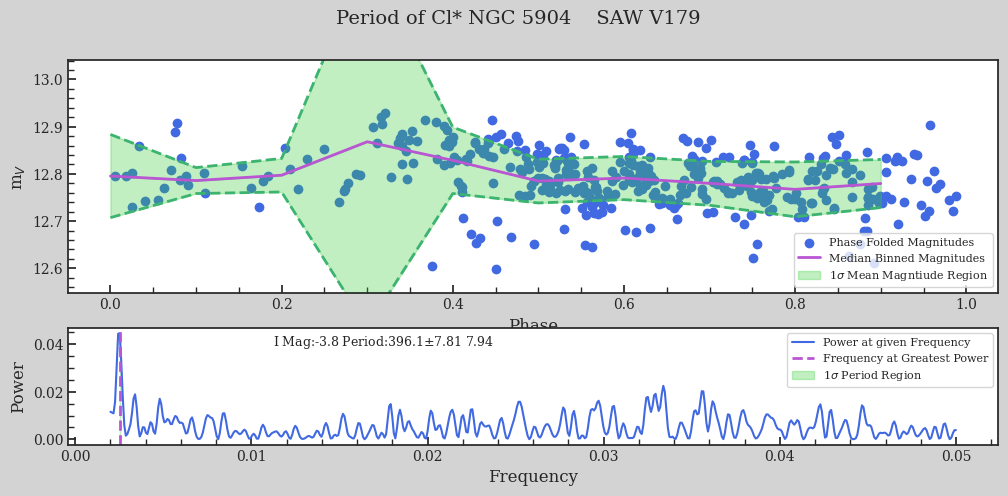

15 18 28.8652 +02 05 44.295 -3.717517852783203
9.506871478630195


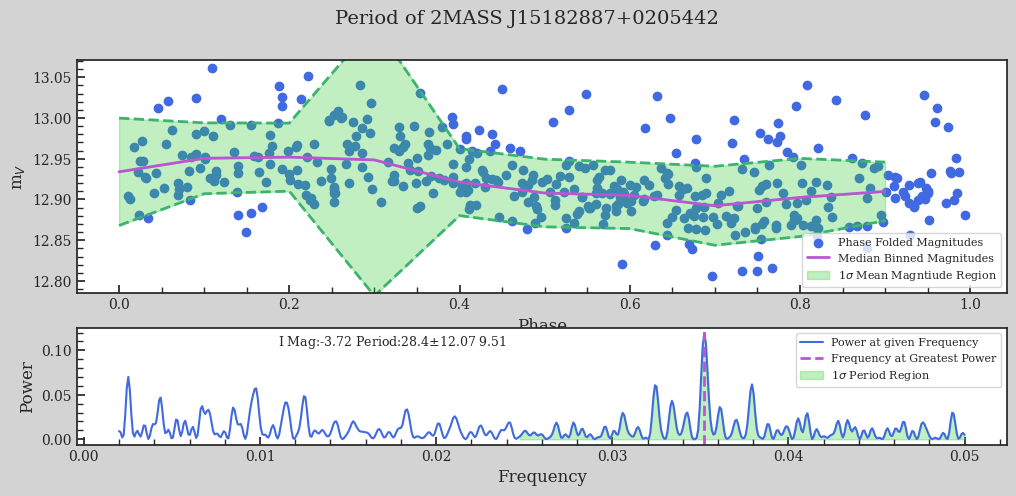

15 18 37.42 +02 06 32.3 -3.6975183486938477
6.671982809747131


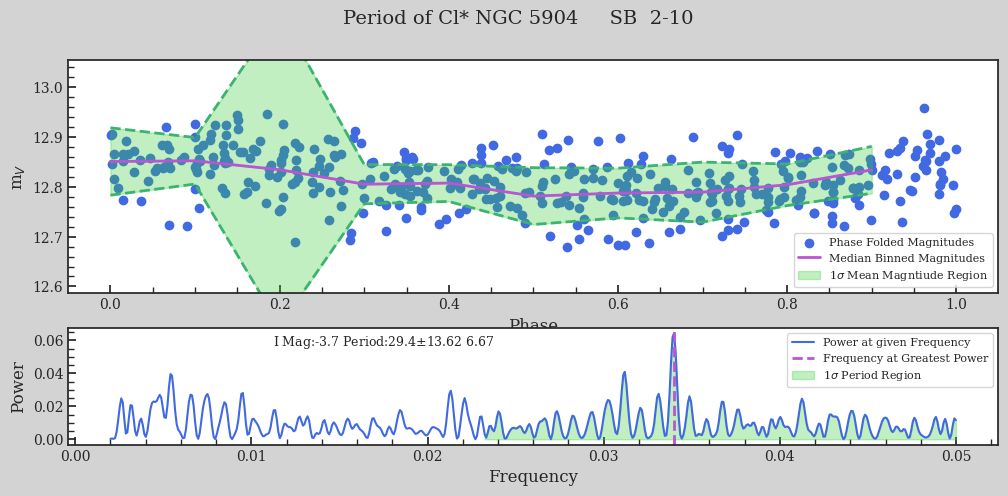

15 18 36.2254 +02 05 11.047 -3.5129175186157227
10.898175793421457


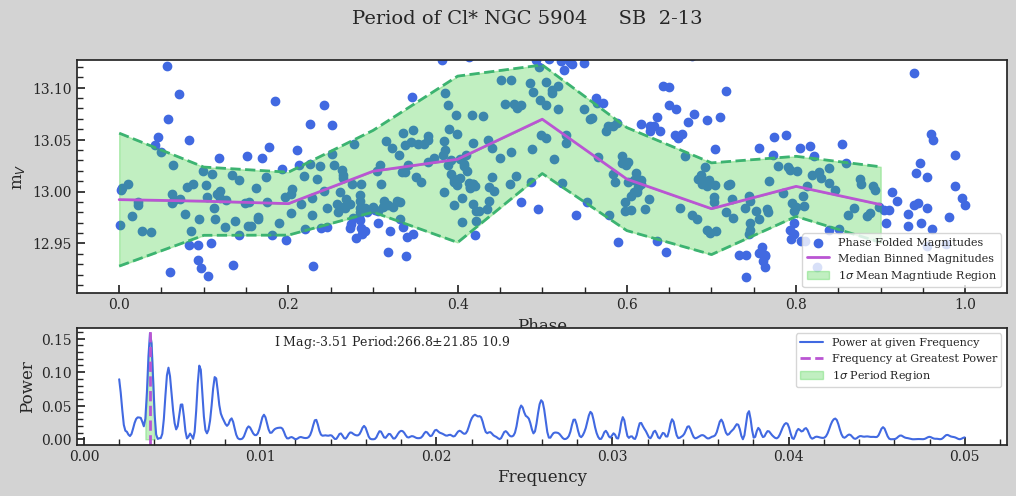

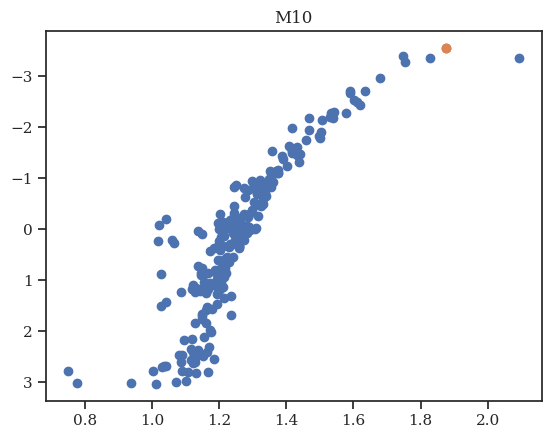

1
16 57 10.7671 -04 04 43.911 -3.546053886413574
5.5522831961413


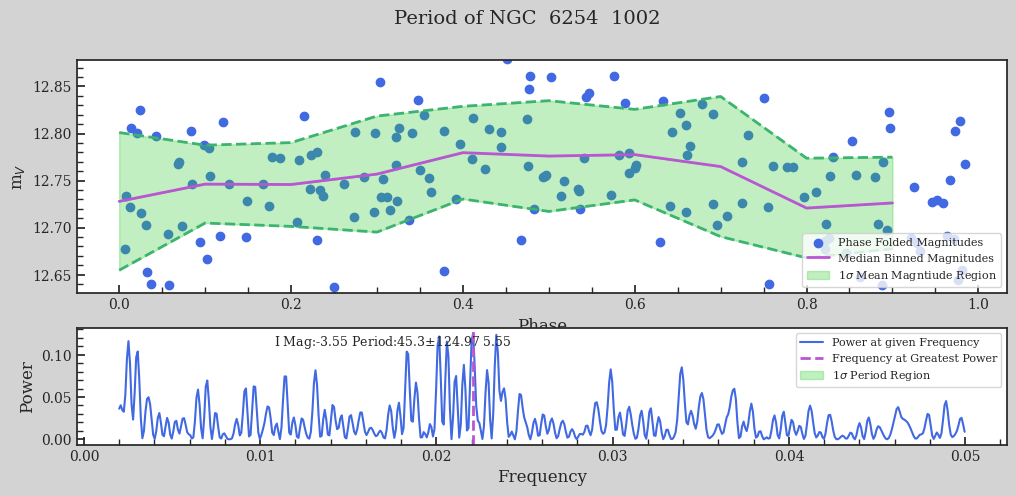

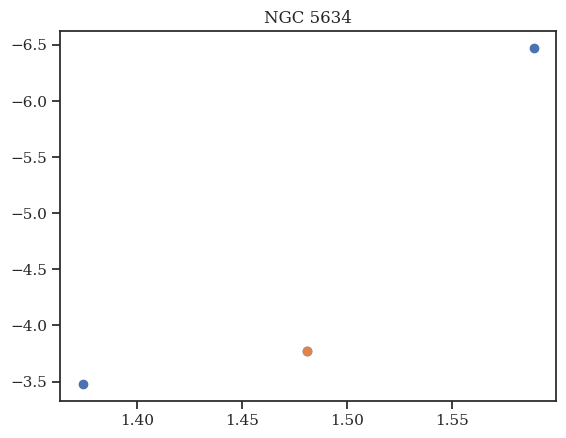

1
14 29 30.0602 -05 58 39.402 -3.776439666748047
18.870867486959188


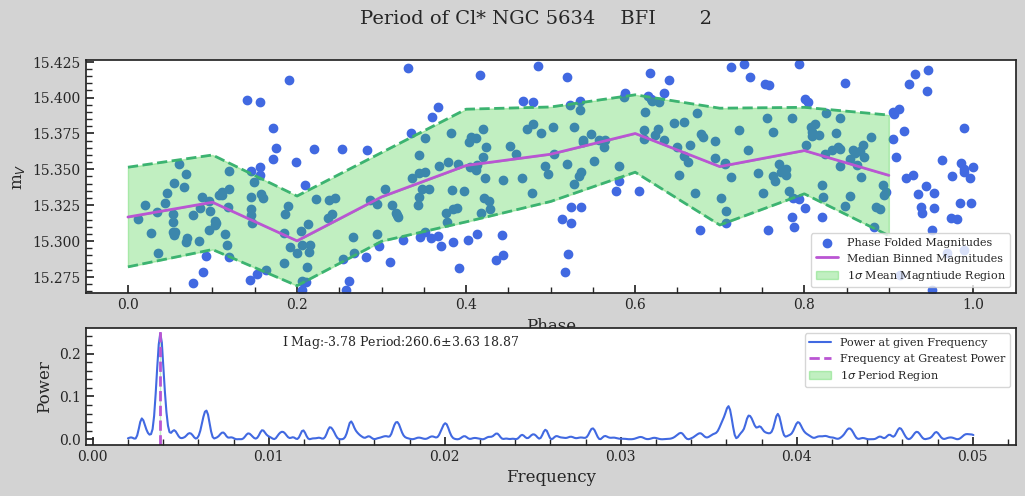

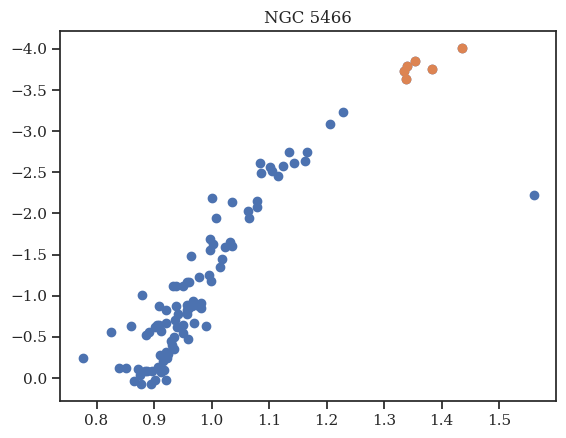

6
14 05 04.6923 +28 36 03.236 -3.6318254470825195
4.1591598168445465


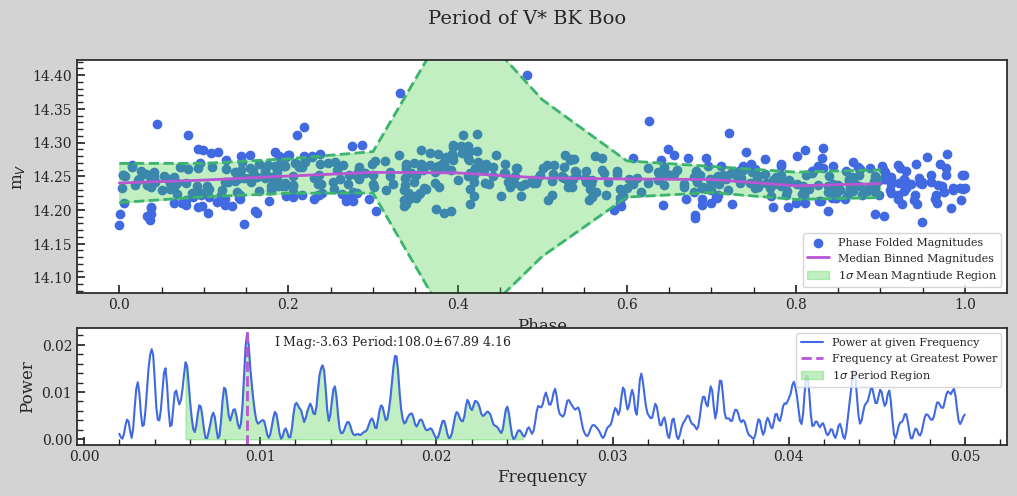

14 06 13.7009 +28 30 14.022 -4.008825302124023
12.367841476891883


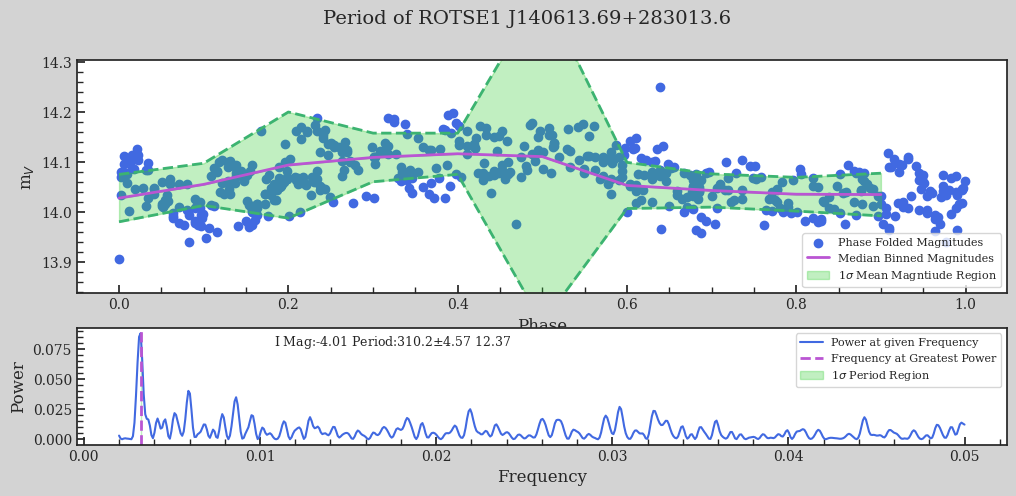

14 05 22.8176 +28 30 13.760 -3.852825164794922
4.0448937745393465


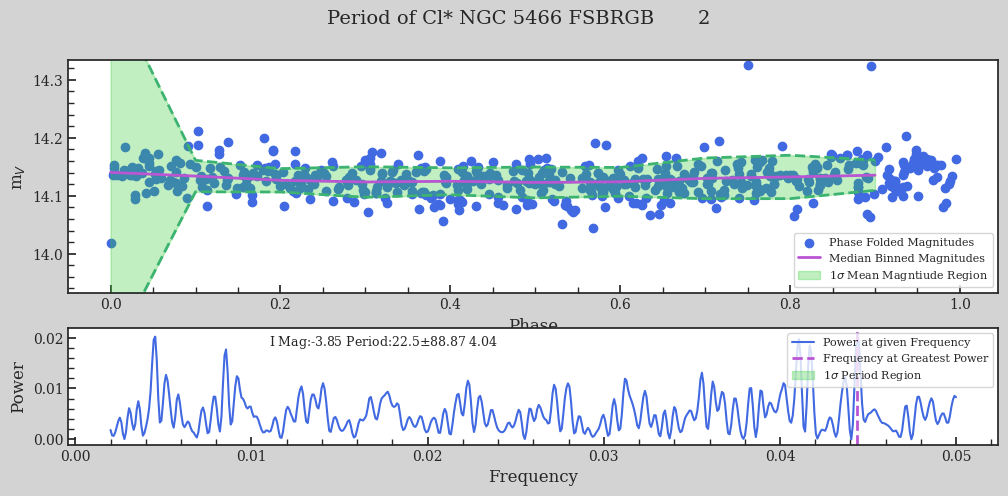

14 05 39.2790 +28 31 12.848 -3.785824775695801
3.3094192625977015


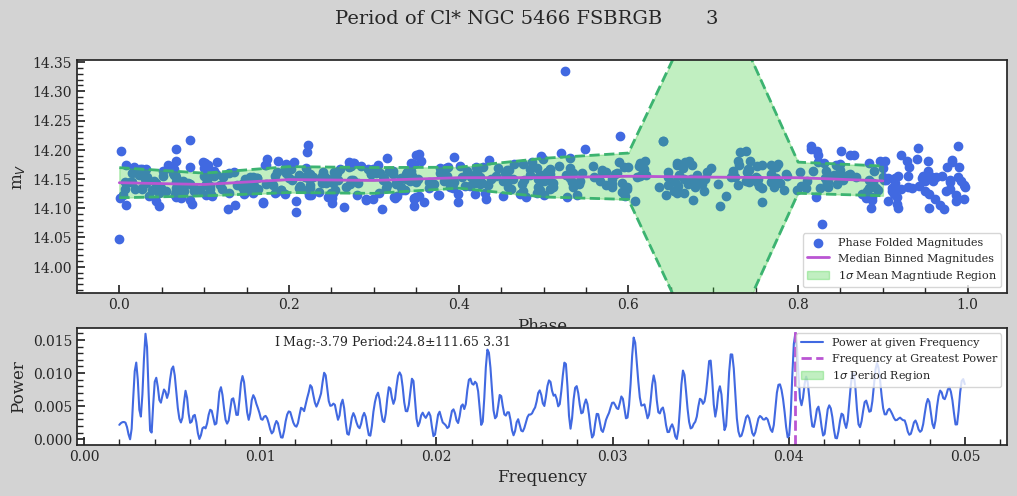

14 05 31.1833 +28 27 15.141 -3.7588253021240234
4.645047592282249


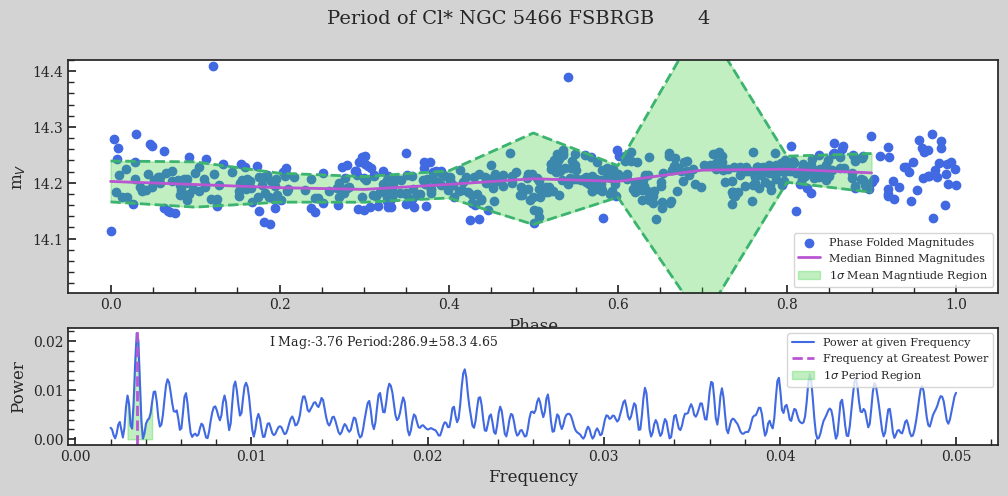

14 05 14.7893 +28 21 47.867 -3.73282527923584
3.6680520699607255


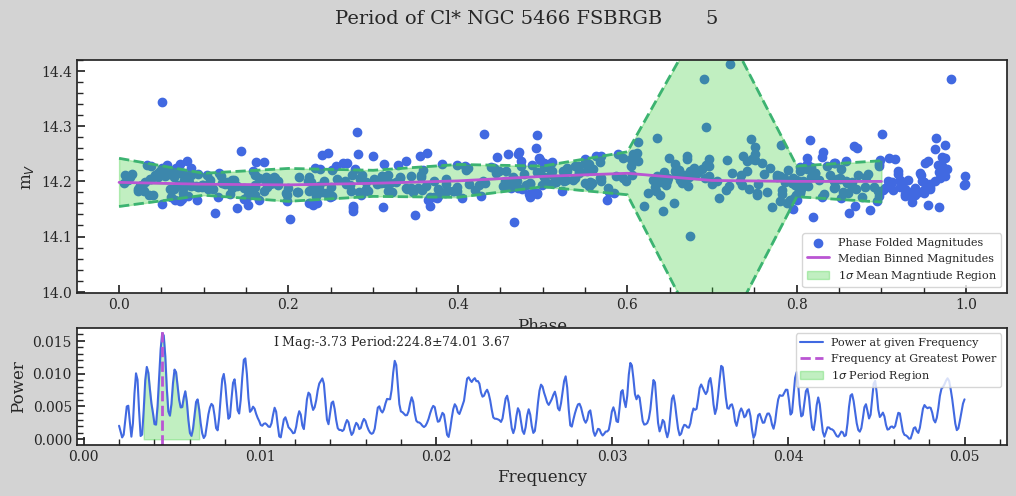

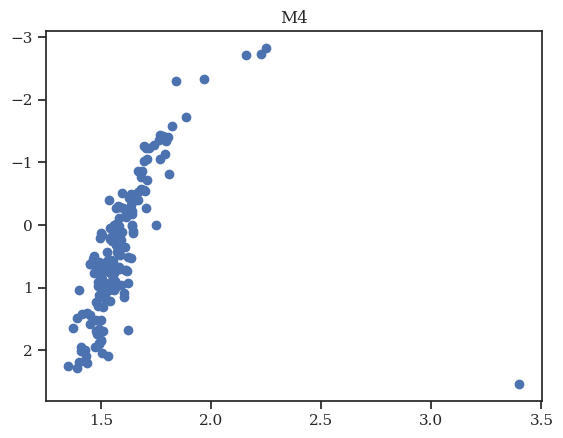

0


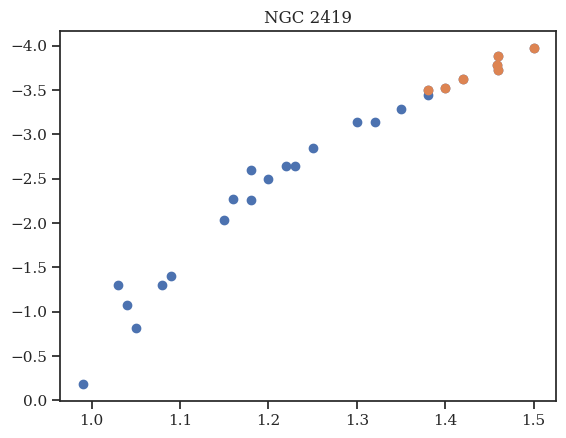

7
07 38 09.7731 +38 50 45.408 -3.9740047454833984
22.01979392624205


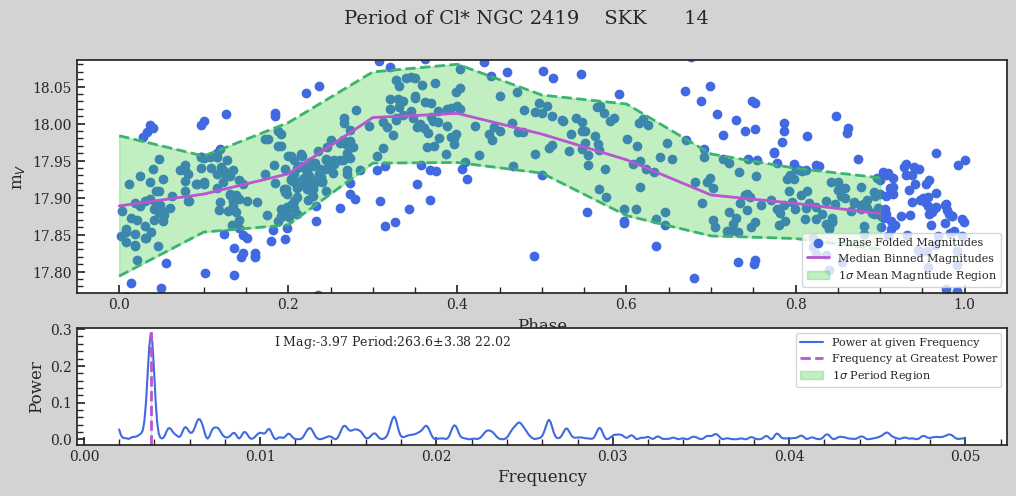

07 38 14.9493 +38 51 51.547 -3.7830047607421875
8.060554911238093


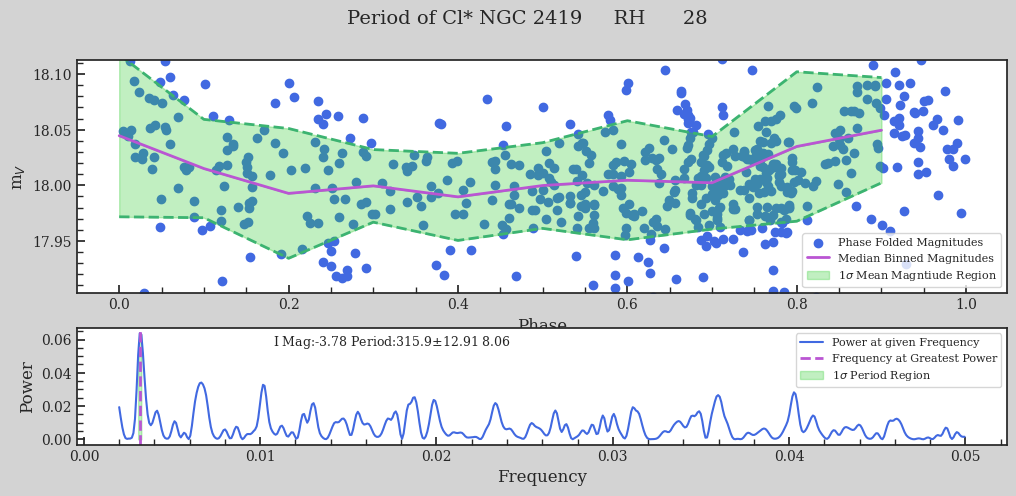

07 38 16.9056 +38 53 35.075 -3.5040054321289062
7.724074248501856


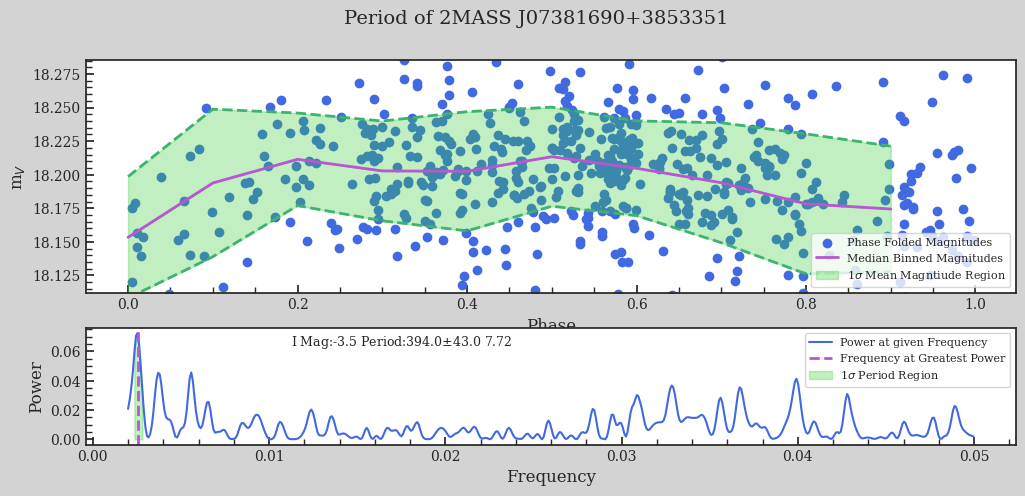

07 38 05.9851 +38 52 05.608 -3.884004592895508
16.350921778855742


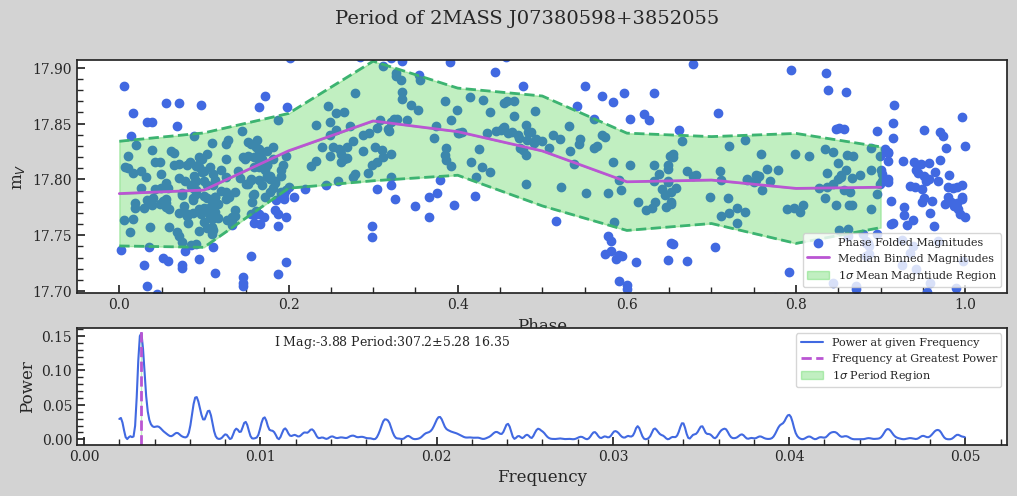

07 38 09.3543 +38 52 10.004 -3.7240047454833984
5.552357911673473


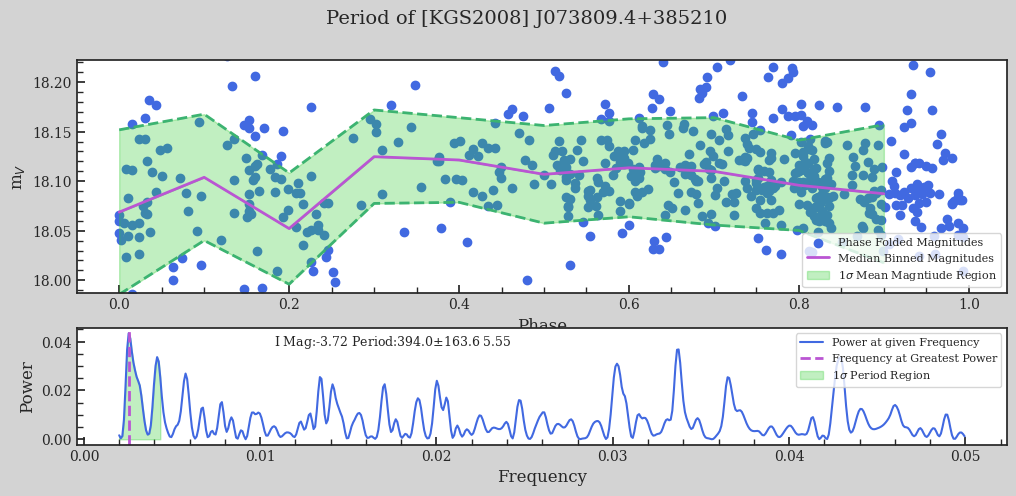

07 38 09.5562 +38 53 38.775 -3.624004364013672
4.794725606137688


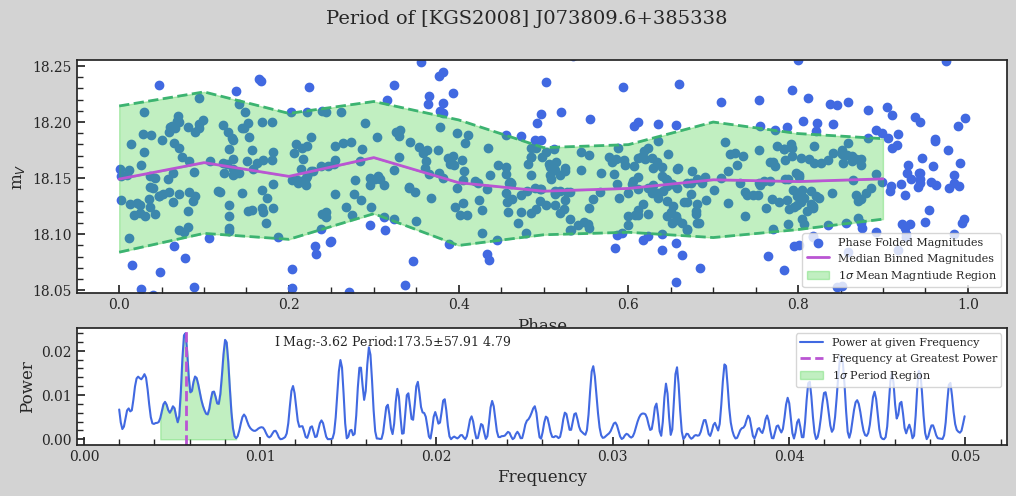

07 38 13.4819 +38 52 57.553 -3.524005889892578
9.588823846657426


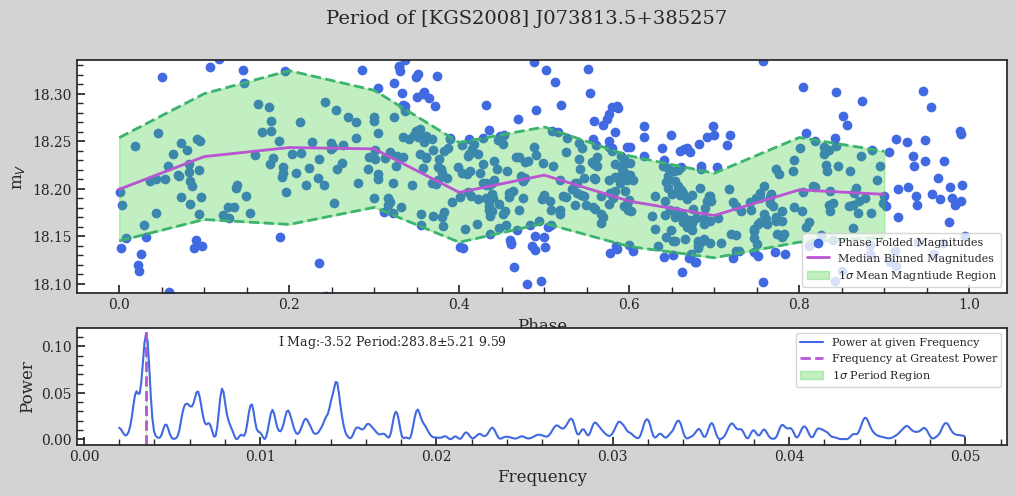

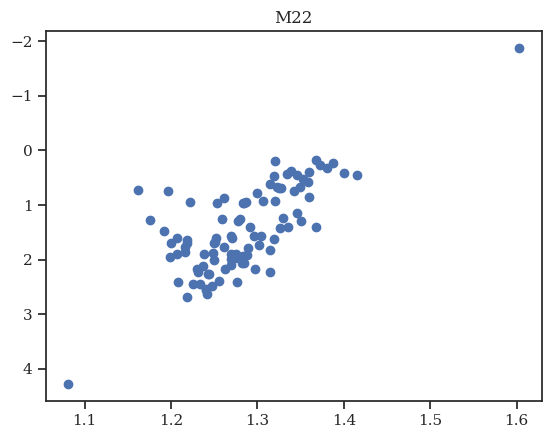

0


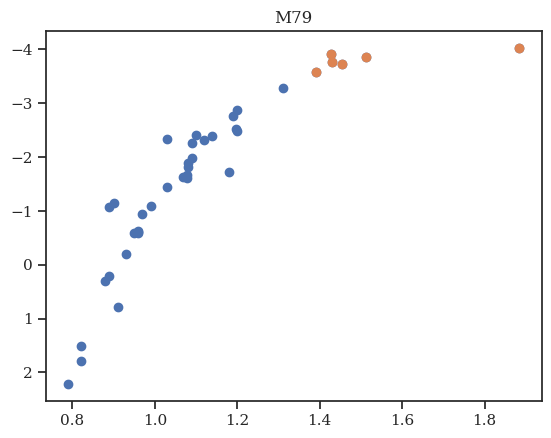

6
05 24 11.1033 -24 30 18.491 -3.5727062225341797
4.637946322213939


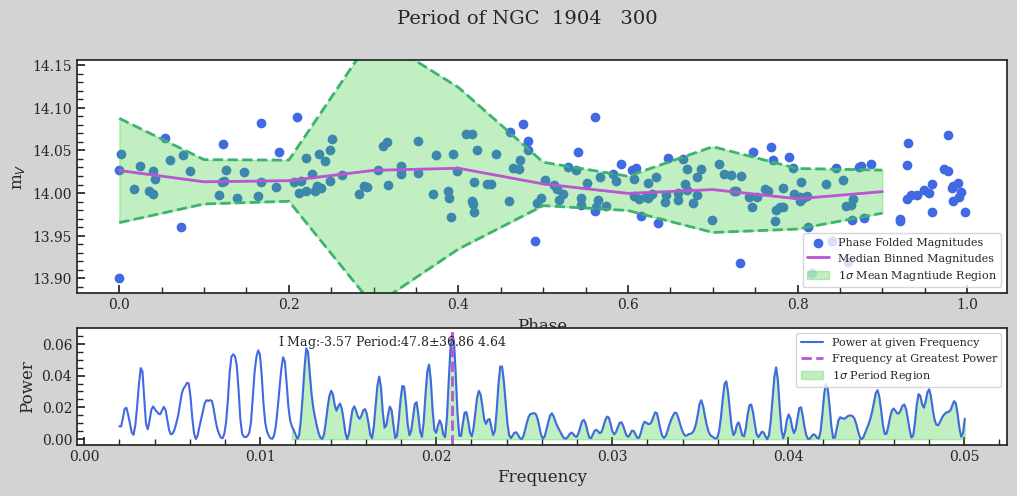

05 24 09.1300 -24 34 16.114 -4.026706695556641
15.745806383557865


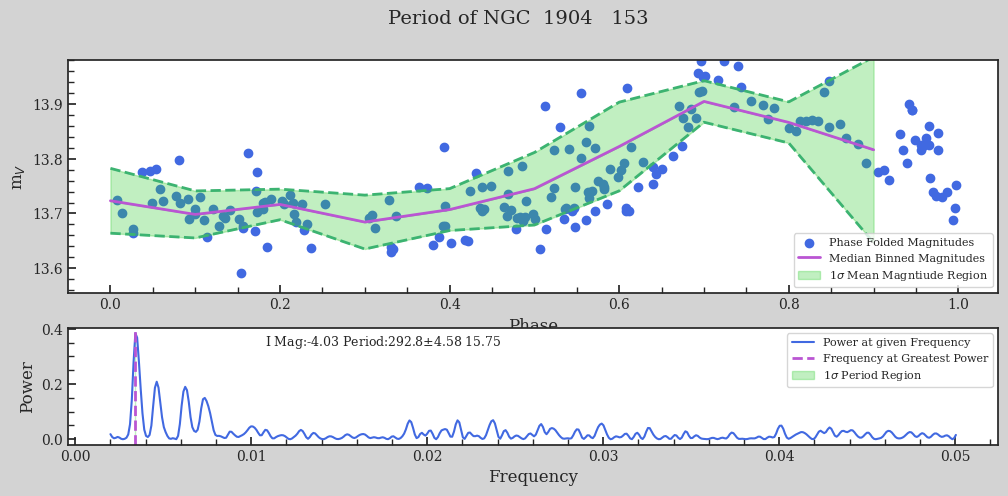

05 24 18.4847 -24 31 43.397 -3.862706184387207
4.532031292912763


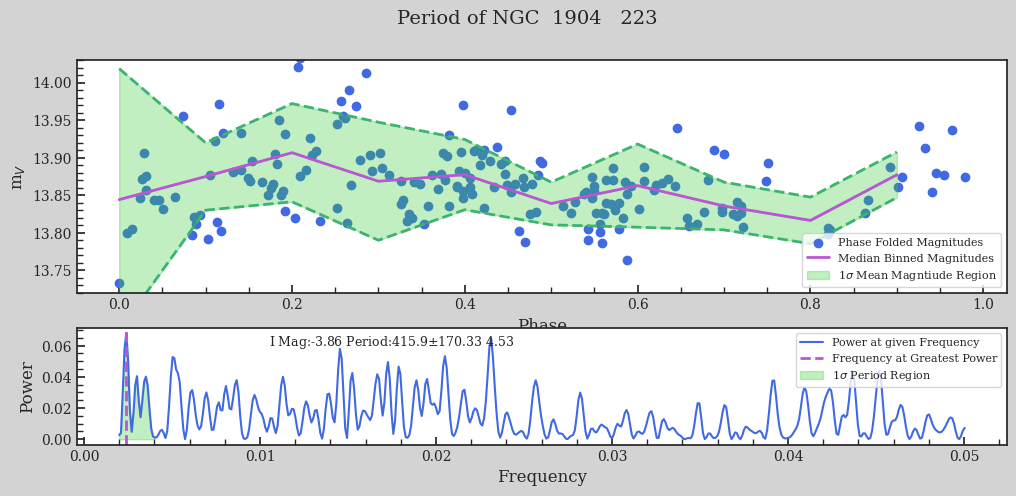

05 24 08.5162 -24 31 51.556 -3.7727060317993164
5.465474502599602


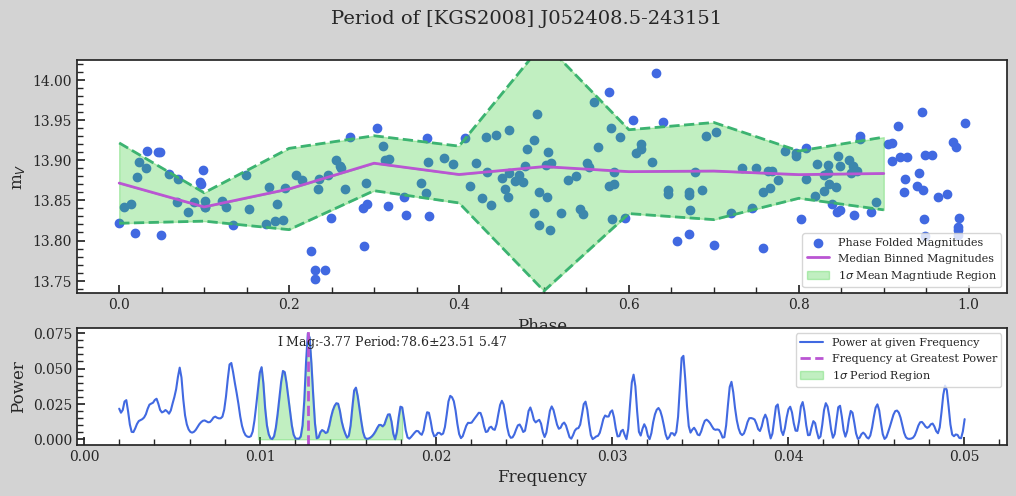

05 24 16.7476 -24 32 34.425 -3.9187068939208984
6.974958804724166


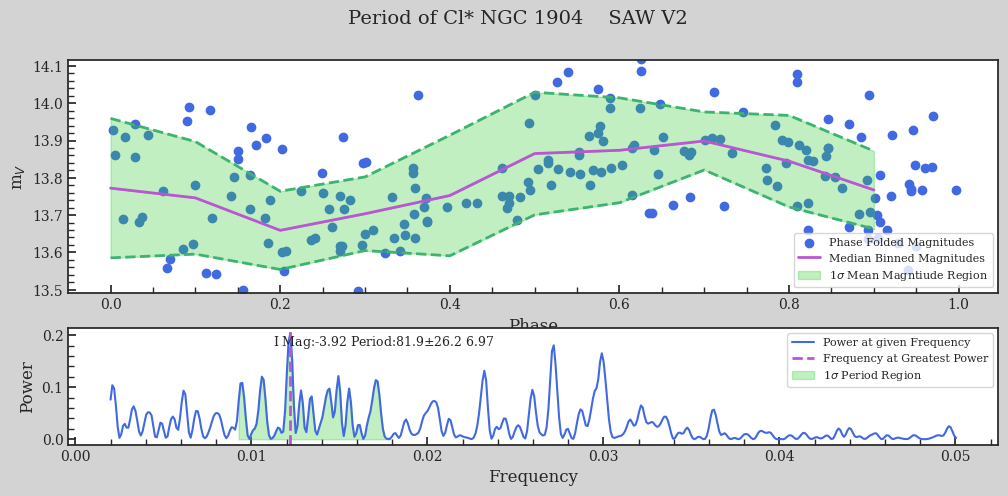

05 23 47.3265 -24 30 37.624 -3.7267065048217773
9.73379472253319


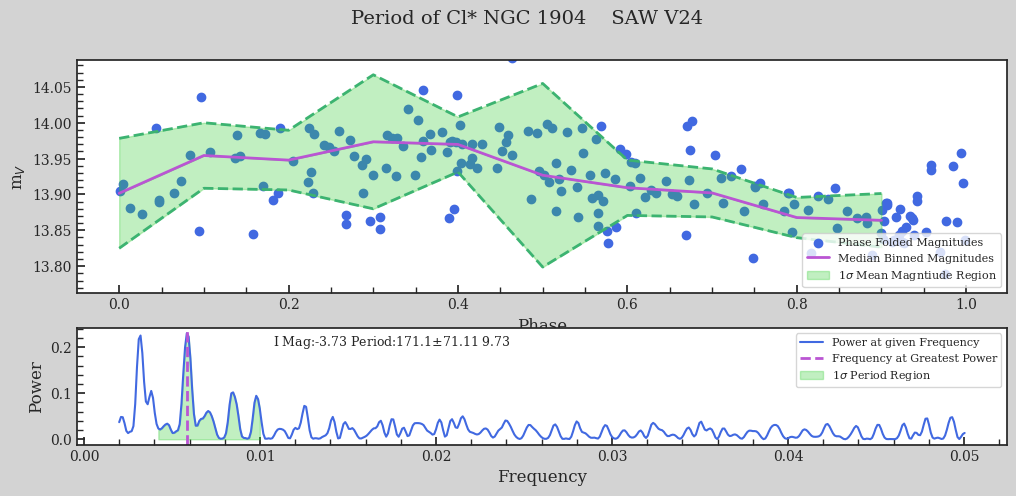

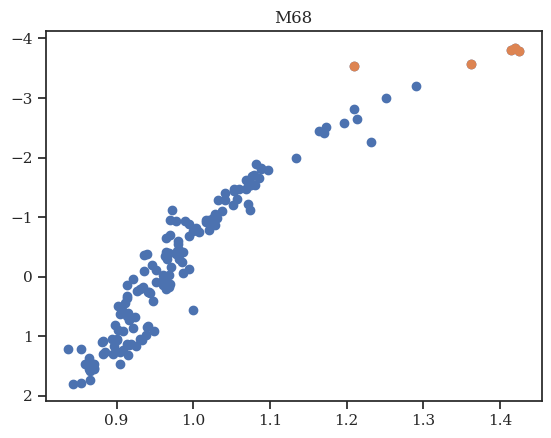

5
12 39 20.8671 -26 46 54.201 -3.8390016555786133
3.2075701693136485


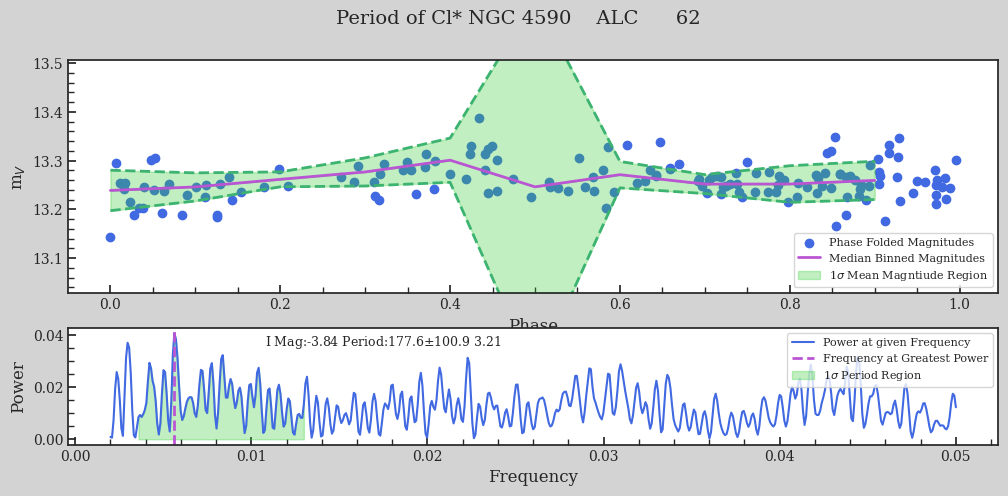

12 39 24.6556 -26 43 33.129 -3.8100013732910156
3.3734278924003904


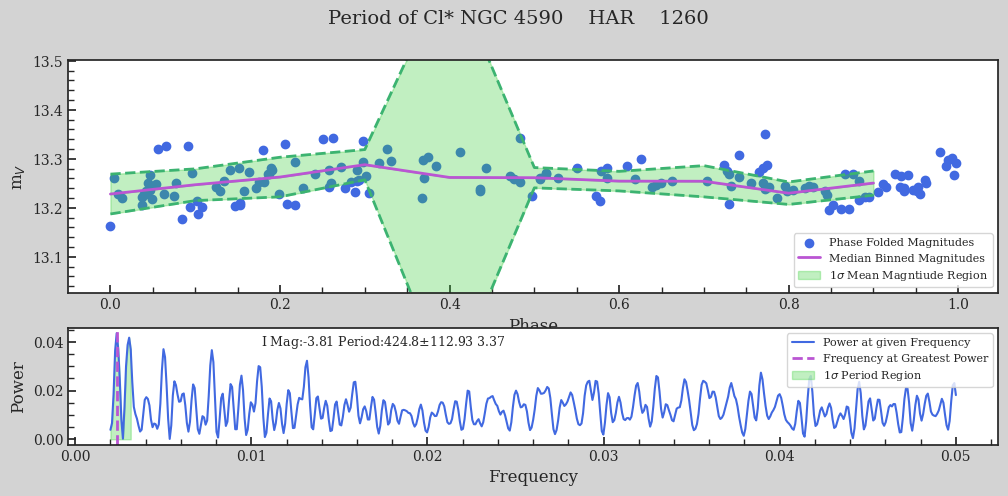

12 39 20.7923 -26 41 39.092 -3.7950010299682617
4.942079135028834


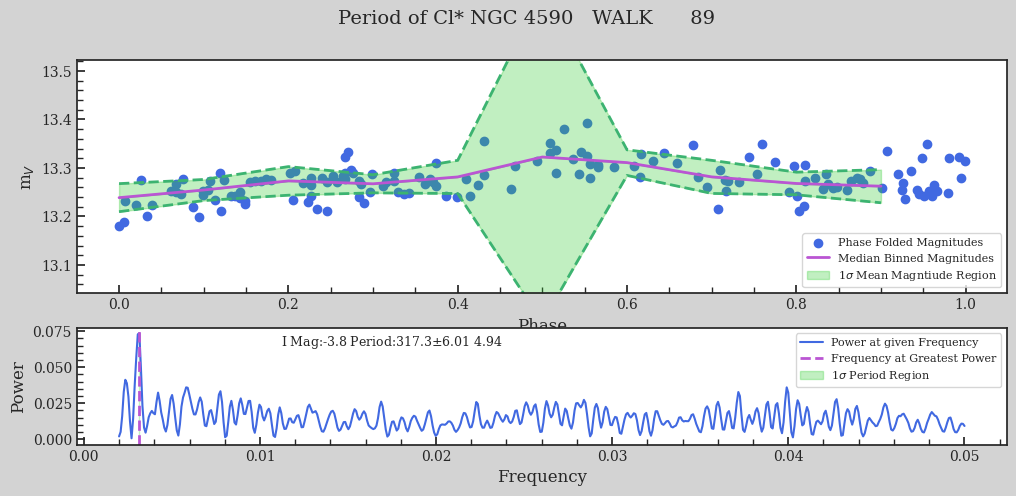

12 39 30.8380 -26 47 52.674 -3.535001754760742
3.6560893464272093


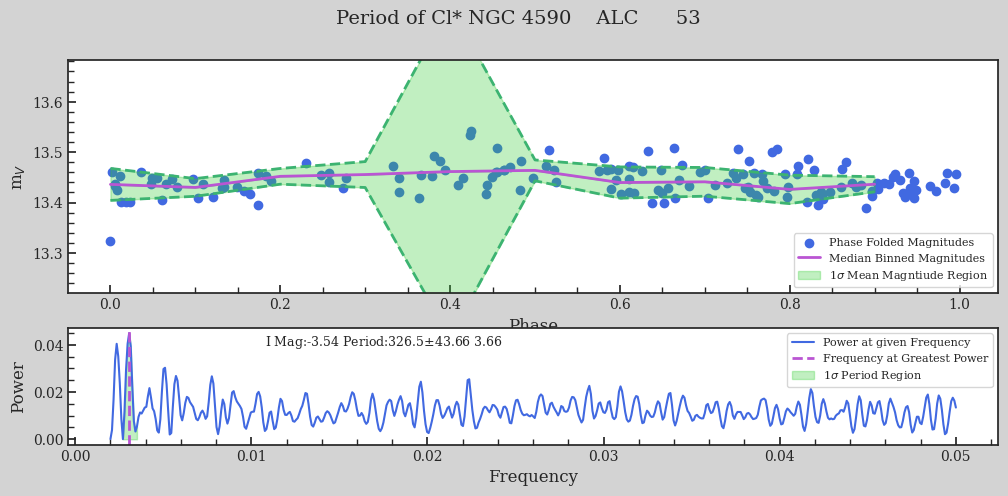

12 39 34.2907 -26 43 23.371 -3.578001022338867
3.0022923494882012


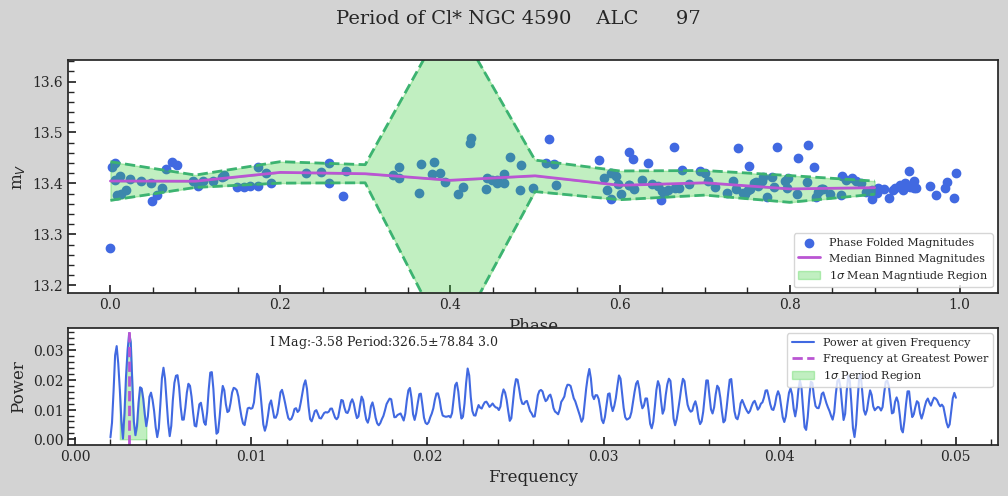

In [169]:
# Show CMD AND gather info on TRGB Stars

# indexing for cluster name
j=-1

# arrays for CMD diagram
nmag, ncolor, imag, icolor, glmag_err = [],[],[],[],[]

# arrays for PL diagmra
periods, perioderrs, trgbmag, trgbmagerr, trgbcolor, powers = [],[],[],[],[],[]

# repeat for each cluster
for result in results: 
    # index for globular cluster naming
    j+=1
    # since some globular clusters do not have RGs, try statement allows code to run
    try:
        # returns visual and color magnitude, ra and dec and star name for each RG found in each cluster
        i_trgb, vi_trgb, ra_trgb, dec_trgb, name, i_non, vi_non, mag_err = cmd(result, j)
        print(len(i_trgb))
        imag.append(i_trgb)
        icolor.append(vi_trgb)
        nmag.append(i_non)
        ncolor.append(vi_non)
        glmag_err.append(mag_err)
        
        # takes TRGB stars and queries for lighcurve data in ZTF
        for q in np.arange(0, len(i_trgb), 1):
            ra, dec = ra_trgb[q], dec_trgb[q]
            print(ra, dec, float(i_trgb[q]))
            if float(i_trgb[q]) != 'nan':
                # since dec is recorded as a string, need to manipulate it to be decimal hours (postive and negative)
                if dec[0] == '+':
                    k = 1
                elif dec[0] == '-':
                    k = -1
                # make the RA and DEC in decimal hours
                ztfra, ztfdec = float(ra[0:2])+float(ra[3:5])/60+float(ra[6:])/3600, k*(float(dec[1:3])+float(dec[4:6])/60+float(dec[7:])/3600)
                # input RGB star RA and DEC into ZTF (ZTF takes degrees instead of hours for RA)
                star = ztf_obj(15*ztfra, ztfdec)
                # if ZTF finds stars
                if star is not None:
                    t = Table.read(star, format='ipac')
                        
                    # Calls lomb-scargle function and plots phase folded lightcurve 
                    period, frequency, power = find_period(t['mag'], t['mjd'], t['magerr'])
                    uncertainty = monte_carlo(frequency, power)
                    phase_fold(t['mag'], t['mjd'], t['magerr'], period, name[q], frequency, power, uncertainty, i_trgb[q]) 
                    # collecting data for period luminosity diagram (yes, there is redudant arrays, this is easier)
                    periods.append(period.value)
                    powers.append(power)
                    perioderrs.append(uncertainty)
                    trgbmag.append(i_trgb[q])
                    trgbmagerr.append(mag_err)
                    trgbcolor.append(vi_trgb[q])
                        
        
    except TypeError:
        continue 

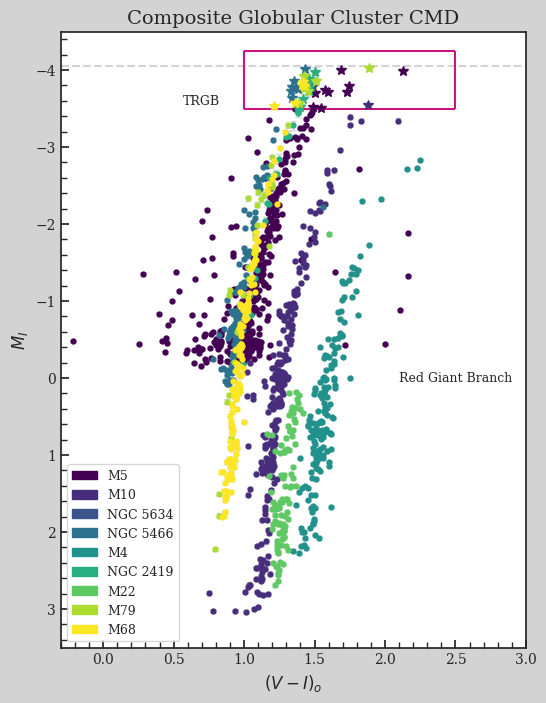

In [142]:
# Use colormap for Globular cluster identification
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(glclist))]

# Set up plot style
sns.set_theme(style="ticks")
plt.rcParams.update({'font.family':'serif'})

# Set up plot format
fig, ax = plt.subplots(figsize=(6,8)) 
ax.set_title('Composite Globular Cluster CMD', fontsize=14)
fig.patch.set_facecolor('lightgray')
ax.set_facecolor('white')
fig.patch.set_edgecolor('navy')

# plot overlay of stars in globular clusters
# assign stars by globular cluster (color) and by TRGB (star) or just RGB (dot)

for i in range(len(glclist)):
    # plot all other stars 
    for j in range(len(nmag[i])):
        ax.errorbar(ncolor[i][j], nmag[i][j], yerr=[[glmag_err[i][0]], [glmag_err[i][1]]], color=colors[i], marker='.', ecolor='lightgray',markersize=7,capsize=2,capthick=1,elinewidth=1)
    # plot TRGBs
    for k in range(len(imag[i])):    
        ax.errorbar(icolor[i][k], imag[i][k], yerr=[[glmag_err[i][0]], [glmag_err[i][1]]], color=colors[i], marker='*', ecolor='lightgray',markersize=7,capsize=2,capthick=1,elinewidth=1)
 
# Plot box area for TRGBs based on I magnitudes
ax.axhline(-4.056, color='lightgrey', ls='--')
ax.vlines(x = 1, ymin = -4.25, ymax = -3.5,
           colors = 'mediumvioletred')
ax.vlines(x = 2.5, ymin = -4.25, ymax = -3.5,
           colors = 'mediumvioletred')
ax.hlines(y = -3.5, xmin = 1, xmax = 2.5,
           colors = 'mediumvioletred')
ax.hlines(y = -4.25, xmin = 1, xmax = 2.5,
           colors = 'mediumvioletred')

# plotting text
ax.text(0.7, -3.6,
            f'TRGB',
            fontsize=9,
            horizontalalignment='center',
            verticalalignment='center')
ax.text(2.5, 0,
            f'Red Giant Branch',
            fontsize=9,
            horizontalalignment='center',
            verticalalignment='center')

# plot labels and limits
ax.set_ylabel(f'$M_I$', fontsize=12)
ax.set_xlabel(f'$(V-I)_o$', fontsize=12)
ax.set_ylim(-4.5, 3.5)
ax.set_xlim(-0.3, 3)

# tick formatting
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=10,direction='in')
ax.tick_params(axis='both', which='minor', labelsize=6,direction='in')

# Define custom legend elements
legend_handles = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, glclist)]

# Add custom legend
ax.legend(handles=legend_handles, loc=3, fontsize='9')

# micsalnious formatting
ax.invert_yaxis()
ax.set_aspect(aspect='auto')
ax.grid(False)
plt.savefig(os.path.join('/Users/thomas/Downloads/', 'CMD.png'))

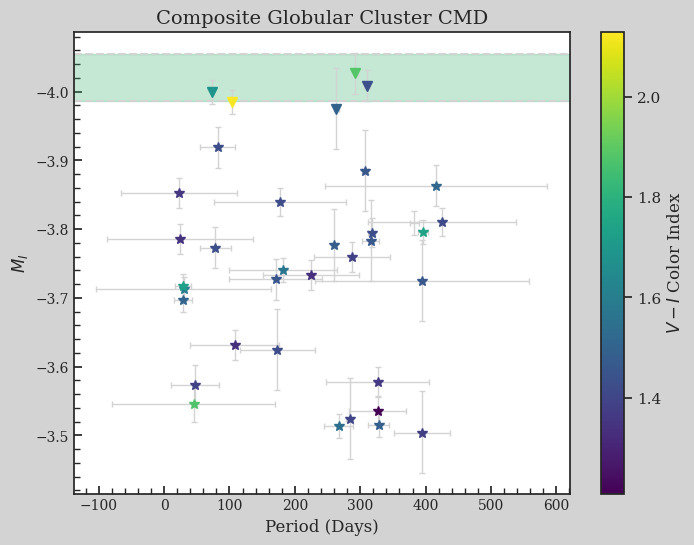

In [170]:
# Define a linear model
def linear_model(B, x):
    return B[0] * x + B[1]

# Creates a linear model using periods and magnitudes with thier uncertainties
linear = odr.Model(linear_model)
data = odr.RealData(periods, trgbmag, sx=np.array(perioderrs)/np.array(periods), sy=np.array(trgbmagerr).T[0])

# Perform the fit with arbitary guesses for intital parameters
odr_obj = odr.ODR(data, linear, beta0=[1., 1.])  
output = odr_obj.run()

# Extract fit parameters and uncertainties
slope, intercept = output.beta
slope_err, intercept_err = output.sd_beta

# arrays to show linear fit
x = np.linspace(min(periods), max(periods), 50)
y_fit = linear_model([slope, intercept], x)

# yes we are doing another color map
norm = Normalize(vmin=min(trgbcolor), vmax=max(trgbcolor))
colors = cmap(norm(trgbcolor))

# yay, more plot formatting, hehe
sns.set_theme(style="ticks")
plt.rcParams.update({'font.family':'serif'})

# Set up plot format
fig, ax = plt.subplots(figsize=(8,6)) 
ax.set_title('Composite Globular Cluster CMD', fontsize=14)
fig.patch.set_facecolor('lightgray')
ax.set_facecolor('white')
fig.patch.set_edgecolor('navy')

# plotting the data, need a loop because of colors
for a,b,c,d,e in zip(periods, trgbmag, np.array(trgbmagerr), perioderrs, colors):
    if b > -3.95:
        ax.errorbar(a, b, yerr=[[c[0]], [c[1]]], ls='',xerr=d, marker='*', color=e, ecolor='lightgray',markersize=7,capsize=2,capthick=1,elinewidth=1)
    elif b <= -3.95:
        ax.errorbar(a, b, yerr=[[c[0]], [c[1]]], ls='',xerr=d, marker='v', color=e, ecolor='lightgray',markersize=7,capsize=2,capthick=1,elinewidth=1)
# plot linear fit
#ax.plot(x, y_fit, color='mediumvioletred', label=f'Fit line: y = {slope:.2f}x + {intercept:.2f}')

'''
# Adding circles and box to indicate important features 
circle1 = mpatches.Ellipse((90, -3.99), width=100, height=100*ax.get_data_ratio(), color='mediumorchid', fill=False)
ax.add_patch(circle1)
circle2 = mpatches.Ellipse((382, -3.81), width=33, height=33*ax.get_data_ratio(), color='mediumorchid', fill=False)
ax.add_patch(circle2)
circle3 = mpatches.Ellipse((33, -3.71), width=33, height=33*ax.get_data_ratio(), color='mediumorchid', fill=False)
ax.add_patch(circle3)
circle4 = mpatches.Ellipse((270, -3.51), width=33, height=33*ax.get_data_ratio(), color='mediumorchid', fill=False)
ax.add_patch(circle4)
'''
ax.axhline(-4.054, color='lightgrey', ls='--')
ax.axhline(-4.054+0.068, color='lightgrey', ls='--')
ax.axhspan(xmin=-100,xmax=600,ymin=-4.054,ymax=-4.054+0.068, color='mediumseagreen', alpha=0.3)

# here we are attaching the colorbar to show which stars have which color
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label=r'$V-I$ Color Index')

# hehe more plot formatting
ax.set_ylabel(f'$M_I$', fontsize=12)
ax.set_xlabel(f'Period (Days)', fontsize=12)
#ax.set_ylim(-4.1, -3.75)

# tick formatting
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=10,direction='in')
ax.tick_params(axis='both', which='minor', labelsize=6,direction='in')
ax.invert_yaxis()

#ax.set_aspect(aspect='auto')
ax.grid(False)
plt.savefig(os.path.join('/Users/thomas/Downloads/', 'CMD-TRGB.png'))